In [ ]:
import pandas as pd
data = pd.read_csv("../dataset/AEP_hourly.csv")
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Ordenar por la columna 'Fecha' en orden ascendente
df_sorted = data.sort_values(by='Datetime', ascending=True, ignore_index=True)
df_sorted.to_csv("../dataset/AEP_hourly.csv", index=False)

Procesada instancia 0
Procesada instancia 1000
Change detected at index 1215
Procesada instancia 2000
Procesada instancia 3000
Procesada instancia 4000
Procesada instancia 5000
Change detected at index 5887
Procesada instancia 6000
Procesada instancia 7000
Procesada instancia 8000
Change detected at index 8127
Procesada instancia 9000
Procesada instancia 10000
Change detected at index 10527
Procesada instancia 11000
Procesada instancia 12000
Procesada instancia 13000
Procesada instancia 14000
Change detected at index 14015
Procesada instancia 15000
Procesada instancia 16000
Change detected at index 16095
Procesada instancia 17000
Procesada instancia 18000
Procesada instancia 19000
Change detected at index 19135
Procesada instancia 20000
Procesada instancia 21000
Procesada instancia 22000
Change detected at index 22687
Procesada instancia 23000
Procesada instancia 24000
Procesada instancia 25000
Procesada instancia 26000
Procesada instancia 27000
Change detected at index 27743
Procesada

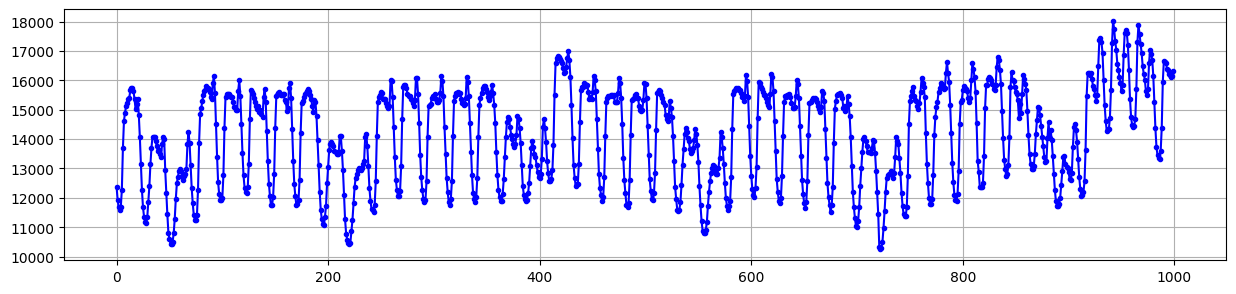

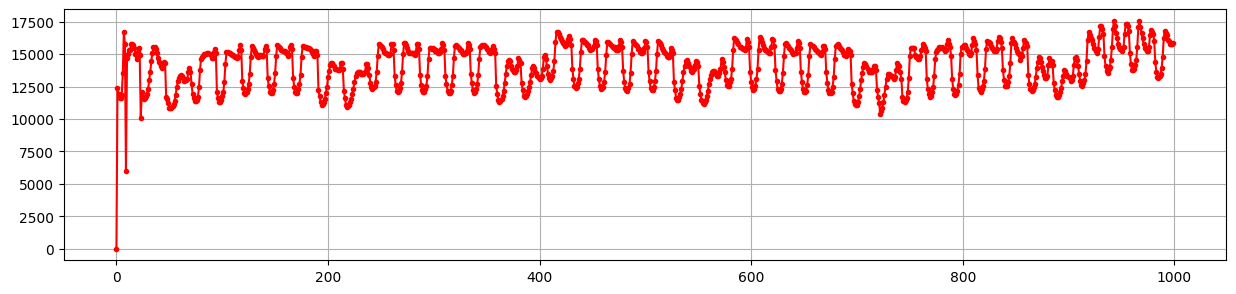

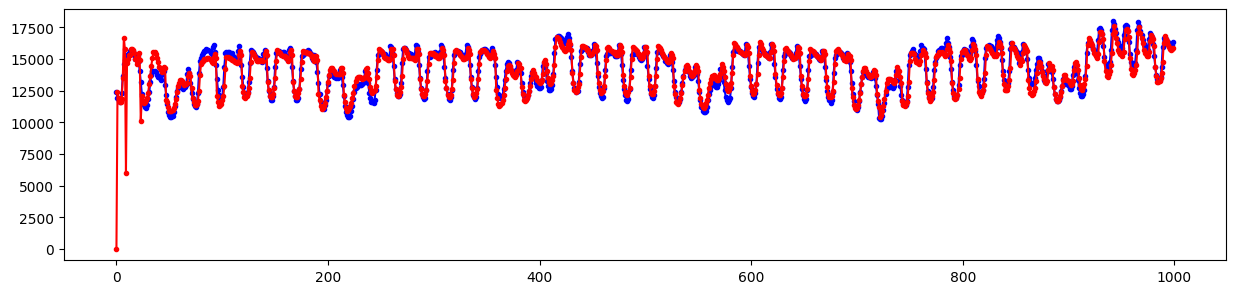

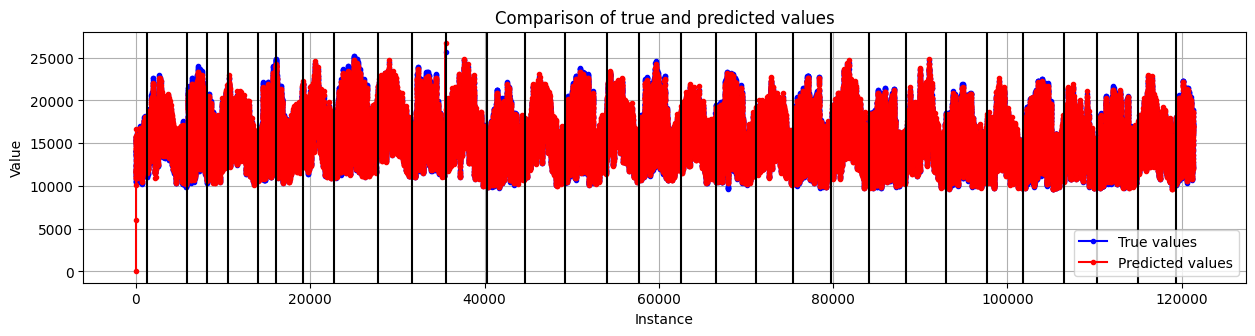

In [6]:
from river import stream, compose, preprocessing, evaluate, metrics, linear_model, utils, stats, feature_extraction
from river.tree import HoeffdingTreeRegressor
import datetime
import matplotlib.pyplot as plt
from river.drift import PageHinkley, KSWIN, ADWIN

dataset_path = "../dataset/AEP_hourly.csv"

def float_converter(a):
    try:
        a=float(a)
    except ValueError:
        a=None
    return a

past_metrics = {"Last": 0}

def divide_date(x):#feature enginnering
    try:
        dt = datetime.datetime.strptime(x['Datetime'], "%Y-%m-%d %H:%M:%S")
        x["Year"]=dt.year
        x["Month"]=dt.month
        x["Day"]=dt.day
        x["WeekOfYear"]=dt.isocalendar().week
        x["DayOfWeek"]=dt.weekday()
        x["DayOfYear"]=dt.timetuple().tm_yday
        x["Weekend"]= int(dt.weekday() >= 5)
        x["Quarter"]=int((dt.month - 1) // 3 + 1)
        x["Hour"]=dt.hour
        x["Last"]=past_metrics["Last"]
    except:
        x["Year"] = None
        x["Month"] = None
        x["Day"] = None
        x["WeekOfYear"] = None
        x["DayOfWeek"] = None
        x["DayOfYear"] = None
        x["Weekend"] = None
        x["Quarter"] = None
        x["Hour"] = None
        x["Last"] = None
    return x

energy_consumption = stream.iter_csv(dataset_path, target="AEP_MW", drop_nones=True, converters={'AEP_MW':float_converter})

model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('date_features', compose.FuncTransformer(divide_date)),
        ('last_7_mean', feature_extraction.TargetAgg(by=None, how=utils.Rolling(stats.Mean(),7),target_name="last_7_mean")),
        ('last_14_mean', feature_extraction.TargetAgg(by=None, how=utils.Rolling(stats.Mean(),14), target_name="last_14_mean"))
    )),
    ('drop_non_features', compose.Discard('Datetime')),
    ('lin_reg', linear_model.BayesianLinearRegression())
)
drift_detector = ADWIN(delta=0.0000000001)
drifts = []
metric = metrics.RMSE()
metric2 = metrics.RMSE()
y_trues = []
y_preds = []
i=0
previous_value = 0
for x, y in energy_consumption:
    if i % 1 == 0:
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        metric.update(y, y_pred)
        metric2.update(y, previous_value)
        past_metrics["Last"] = y
        previous_value = y
        y_trues.append(y)
        y_preds.append(y_pred)
        error = abs(y - y_pred)
        drift_detector.update(error)   # Data is processed one sample at a time
        if drift_detector.drift_detected:
            # The drift detector indicates after each sample if there is a drift in the data
            print(f'Change detected at index {i}')
            drifts.append(i)
    
    if i % 1000 == 0:
        print(f'Procesada instancia {i}')
    i+=1

print(x)
print(metric)
print(metric2)

plt.figure(figsize=(15,15))
plt.subplot(4,1,1)
plt.plot(y_trues[:1000], marker='.', linestyle='-', color='b', label='True values')
plt.grid(True)

plt.figure(figsize=(15,15))
plt.subplot(4,1,2)
plt.plot(y_preds[:1000], marker='.', linestyle='-', color='r', label='Predicted values')
plt.grid(True)

plt.figure(figsize=(15,15))
plt.subplot(4,1,3)
plt.plot(y_trues[:1000], marker='.', linestyle='-', color='b', label='True values')
plt.plot(y_preds[:1000], marker='.', linestyle='-', color='r', label='Predicted values')

plt.figure(figsize=(15,15))
plt.subplot(4,1,4)
plt.plot(y_trues, marker='.', linestyle='-', color='b', label='True values')
plt.plot(y_preds, marker='.', linestyle='-', color='r', label='Predicted values')
if drifts is not None:
    for drift_detected in drifts:
        plt.axvline(drift_detected, color='black')

# Personalización
plt.title('Comparison of true and predicted values')
plt.xlabel('Instance')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

# Mostrar la gráfica
plt.show()
                            